In [1]:
import numpy as np
from alive_progress import alive_bar
import time
from math import sqrt, pi, exp
import functools
import scipy
from varname import nameof
import os
import re

# import algorithms (ULA, ALDI, NRALDI)
from utils.algorithms import * 
# import mog functions (density etc)
from utils.mog_functions import *
# import plot functions
from utils.plot_functions import *


## Test case "Mixture of Gaussians"  

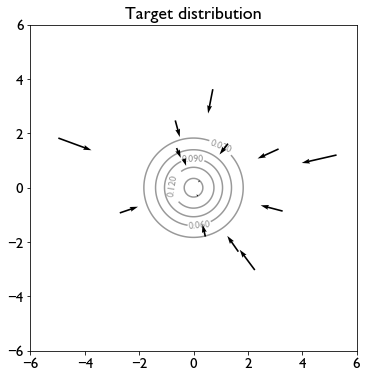

In [2]:
# dimension
d = 2


# parameters of the mixture 

sigma1, sigma2, gap = 1, 1, 0


# define (unnormalized) target density, potential, score (gradient log density)

target_unnorm_density = (lambda z : bimodal_distribution(z, gap, sigma1, sigma2))
# I had to add 1e-9 below to stabilize our scheme with inexact gradients
target_potential = (lambda z: -np.log(target_unnorm_density(z) + 1e-9)) 
gradient_log_target = (lambda z: gradient_of_log_bimodal_distribution(z,  gap, sigma1, sigma2))
#gradient_log_target = (lambda z: - 4*(z-np.ones(2)))




# plot posterior

val = 6
xmin, xmax, ymin, ymax = -val, val, -val, val
nb_grid = 200
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s) # each of the Ui's is of size (200, 200) (all X coordinates of points parallel to Y axis and reverse)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = target_unnorm_density(U) 

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

fig, ax = plt.subplots(figsize = (10, 6))

DS = plt.contour(U0, U1, np.exp(-target_potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target


num_particles = 15
particles = np.random.normal(0, 2, size=(num_particles, d))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        grad_particles[i] +=  gradient_log_target(particles[i,:])


x_pos = particles[:, 0]
y_pos = particles[:, 1]
x_direct = grad_particles[:, 0]
y_direct = grad_particles[:, 1]

ax.quiver(x_pos, y_pos, x_direct, y_direct, width = 0.005)
ax.set_title('Target distribution')
ax.set_aspect('equal')

In [3]:
target_potential(np.zeros((2,2)))

array([1.83787706, 1.83787706])

## Try algorithms on one experiment

In [4]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 500 # number of iterations #### TO CHANGE
d = 2 # dimension
tau = 1e-2 # step size

mean_init = np.asarray([2, 4])
cov_init = [[1, 0], [0, 0.5]]

# parameters of our algorithm
const = 1.5 

# number of experiments
N_exp = 1

### (with exact gradients of the log density of the target - we have access to it in the MOG case)

|███████████████████████████████████████▉⚠︎ (!) 499/500 [100%] in 6.8s (73.51/s) 


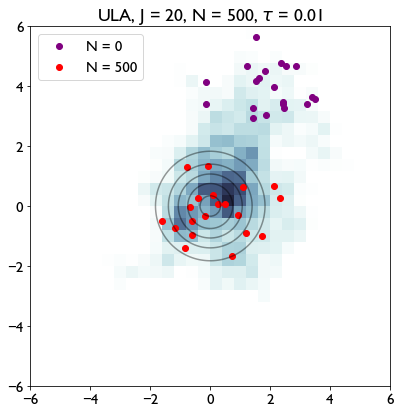

|███████████████████████████████████████▉⚠︎ (!) 499/500 [100%] in 7.1s (70.80/s) 


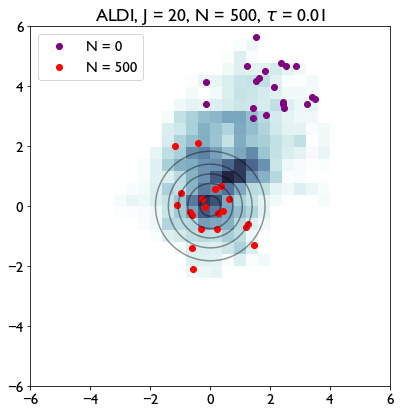

on 0: iter                                                                      
on 0: 0                                                                         
on 0: lambda min                                                                
on 0: 0.4816288736692617                                                        


on 6: /Users/annakorba/Desktop/nreks/utils/algorithms.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff


|███████████████████████████████████████▉⚠︎ (!) 499/500 [100%] in 7.1s (70.81/s) 


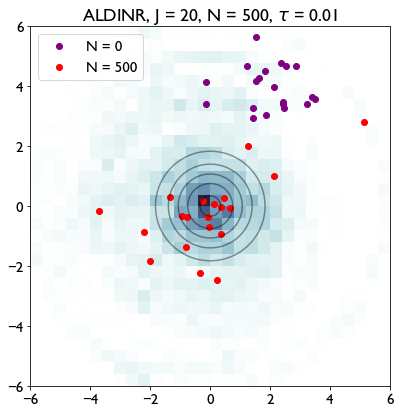

In [5]:

for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    
    # ULA, ALDI and NRALDI with EXACT gradient formula (no approximation)
    us_list_ULA = run_ULA_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
   
    us_list_ALDI = run_ALDI_with_gradient_mog(gradient_log_target, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    
    
    us_list_ALDINR = run_ALDINR_mog(gradient_log_target, N_sim, u0, tau, const) 
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)


In [6]:
u0.shape

(2, 20)

### with inexact gradients 

In [14]:
# 2025: this part is not working

"""
for j in range(N_exp):
    
    # resample initialization
    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T
    
    # ULA, ALDI and NRALDI with inexact gradient formula 

    us_list_ULA_bis = run_ULA(target_potential, N_sim, u0, tau)
    name = nameof(us_list_ULA).lstrip('us_list')    
    plot_results(target_potential, us_list_ULA_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
   
    us_list_ALDI_bis = run_ALDI_with_gradient(target_potential, N_sim, u0, tau)
    name = nameof(us_list_ALDI).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDI_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    
    us_list_ALDINR_bis = run_ALDINR(target_potential, N_sim, u0, tau, const) 
    name = nameof(us_list_ALDINR).lstrip('us_list')    
    plot_results(target_potential, us_list_ALDINR_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
"""

"\nfor j in range(N_exp):\n    \n    # resample initialization\n    u0 = np.random.multivariate_normal(mean_init, cov_init, J).T\n    \n    # ULA, ALDI and NRALDI with inexact gradient formula \n\n    us_list_ULA_bis = run_ULA(target_potential, N_sim, u0, tau)\n    name = nameof(us_list_ULA).lstrip('us_list')    \n    plot_results(target_potential, us_list_ULA_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)\n   \n    us_list_ALDI_bis = run_ALDI_with_gradient(target_potential, N_sim, u0, tau)\n    name = nameof(us_list_ALDI).lstrip('us_list')    \n    plot_results(target_potential, us_list_ALDI_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)\n    \n    us_list_ALDINR_bis = run_ALDINR(target_potential, N_sim, u0, tau, const) \n    name = nameof(us_list_ALDINR).lstrip('us_list')    \n    plot_results(target_potential, us_list_ALDINR_bis, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)\n"

### Important comment: it seems that for big step sizes (0.01), our scheme can crash if we do not regularize the density by 1e-9. 

## Plot some statistics for each scheme on a single experiment

In [8]:
# compute means and covariances

means_ULA, covariances_ULA = compute_means(us_list_ULA), compute_covariances(us_list_ULA)
means_ALDI, covariances_ALDI = compute_means(us_list_ALDI), compute_covariances(us_list_ALDI)
means_ALDINR, covariances_ALDINR = compute_means(us_list_ALDINR), compute_covariances(us_list_ALDINR)

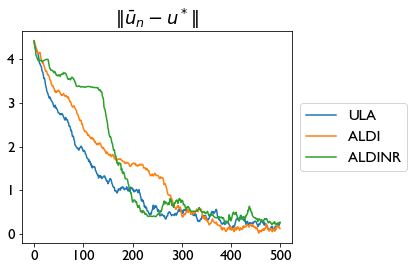

In [9]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'$\Vert \bar{u}_n - u^*\Vert$')
plt.tight_layout()

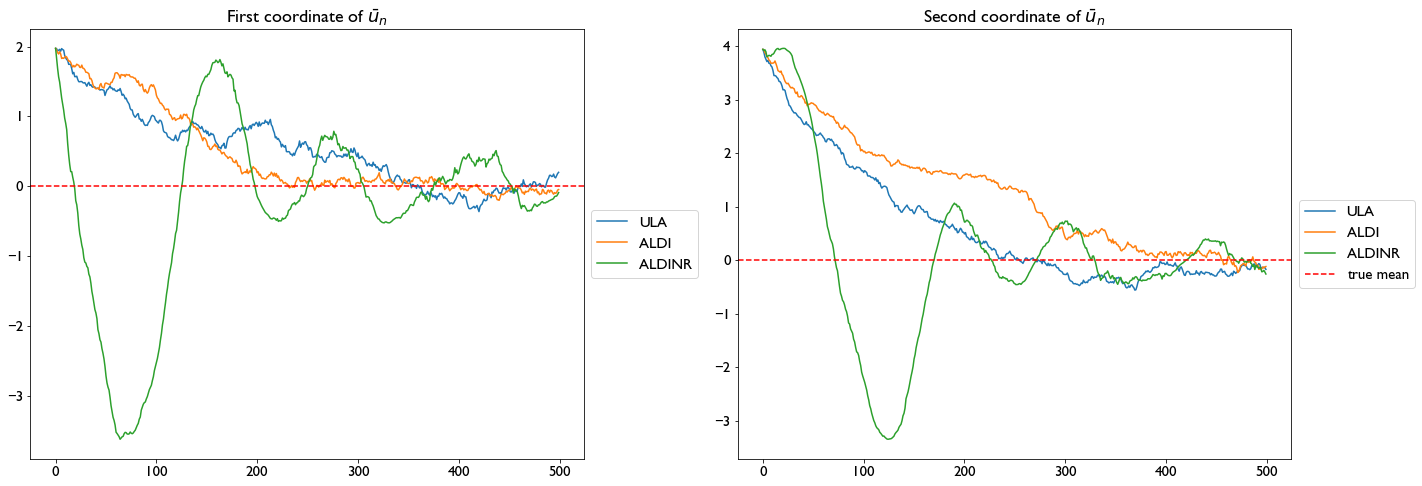

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of '+ r'$\bar{u}_n$')
plt.tight_layout()

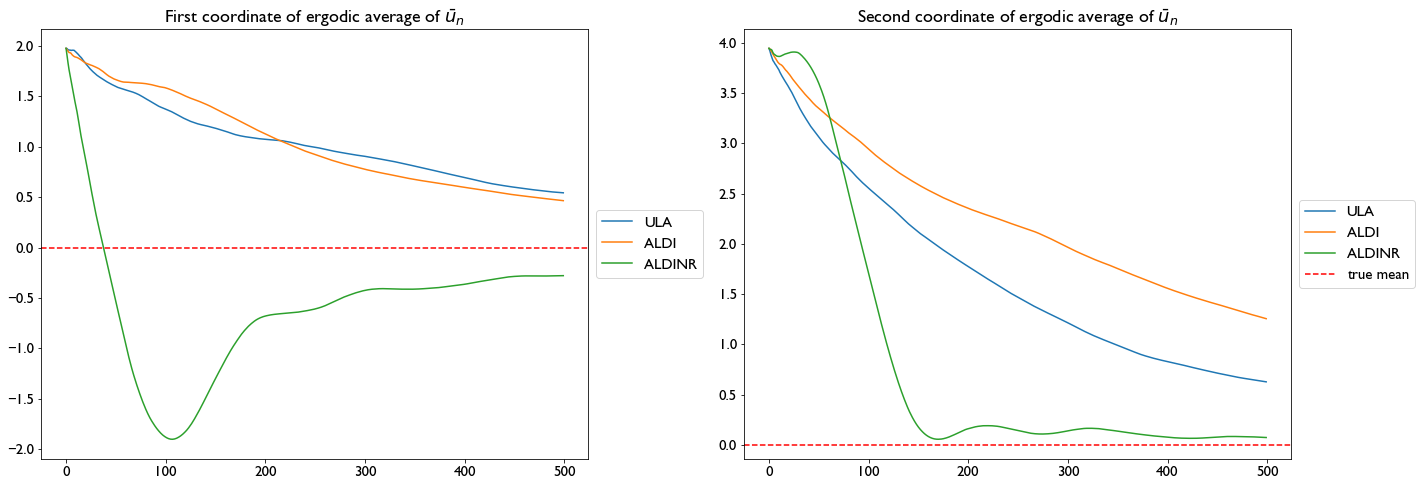

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

# ergodic average
average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('First coordinate of ergodic average of '+ r'$\bar{u}_n$')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Second coordinate of ergodic average of '+ r'$\bar{u}_n$')
plt.tight_layout()

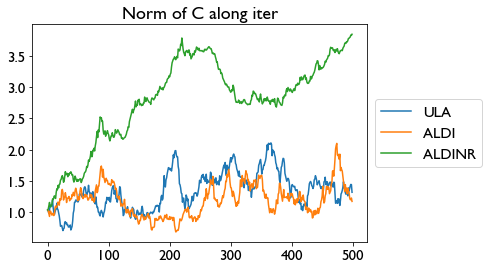

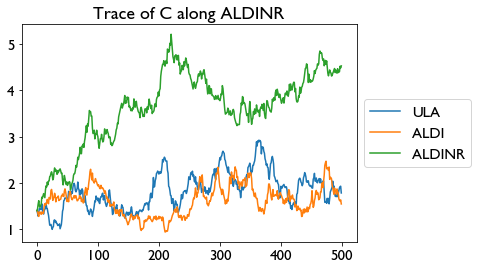

In [12]:

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

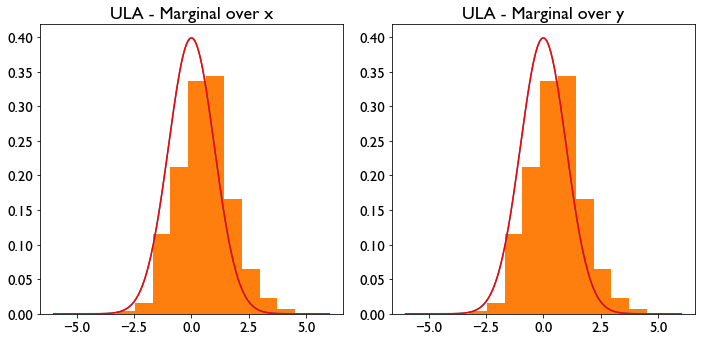

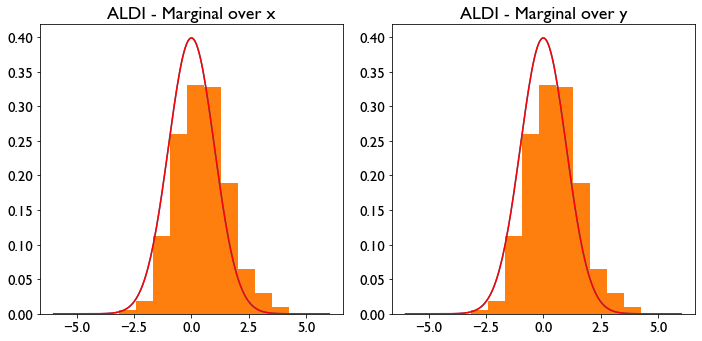

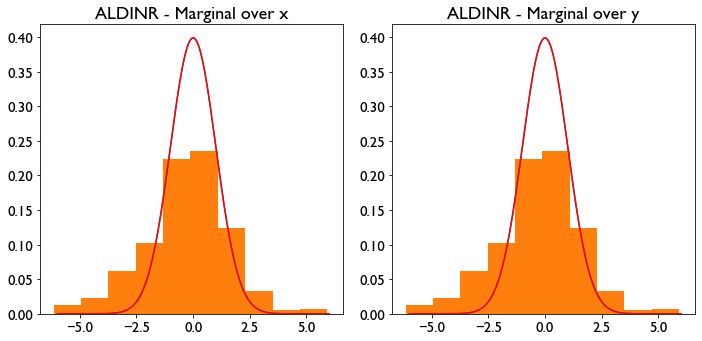

In [13]:
# Plot marginals

plot_marginals_histogram(us_list_ULA, target_unnorm_density, 'ULA')
plot_marginals_histogram(us_list_ALDI, target_unnorm_density, 'ALDI')
plot_marginals_histogram(us_list_ALDINR, target_unnorm_density, 'ALDINR')
